In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
from IPython.display import Image 
#%matplotlib inline
import numpy as np
import dataset_utils
import time

In [2]:
torch.cuda.empty_cache()

In [3]:
import scipy.io as io
matdataset = io.loadmat("matlab_dataset/insect_dataset.mat")
all_dnas = torch.tensor(matdataset['all_dnas']).float().squeeze()
all_labels = torch.tensor(matdataset['all_labels']).float().squeeze()
dnas_1000 = all_dnas[0:1000].unsqueeze(1)
dnas_1000.shape

torch.Size([1000, 1, 658, 5])

In [4]:
from DnaModel import TinyModel
tinymodel = TinyModel()
n_params = dataset_utils.count_trainable_parameters(tinymodel);
print(n_params)
state_dict = torch.load('checkpoints/CNN_DNA_weights_for_unseen')
tinymodel.load_state_dict(state_dict['model_state_dict'])

6452761


<All keys matched successfully>

In [5]:
dnas_1000 = dnas_1000.cuda()
tinymodel.cuda()

TinyModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 1), stride=(1, 1))
  (activation1): LeakyReLU(negative_slope=0.01)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 1, kernel_size=(5, 1), stride=(1, 1))
  (activation2): LeakyReLU(negative_slope=0.01)
  (norm2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=3250, out_features=1500, bias=True)
  (dropout2): Dropout(p=0.7, inplace=False)
  (activation3): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=1500, out_features=1050, bias=True)
)

In [6]:
import random
inference_times = []
for iteration in range(1000):
    index = random.randint(0,all_dnas.shape[0]-1000)
    dnas_1000 = all_dnas[index:index+1000].unsqueeze(1).cuda()
    with torch.no_grad():
        torch.cuda.synchronize()
        start_time = time.time()
        _ = tinymodel.feature_extract(dnas_1000)
        torch.cuda.synchronize()
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

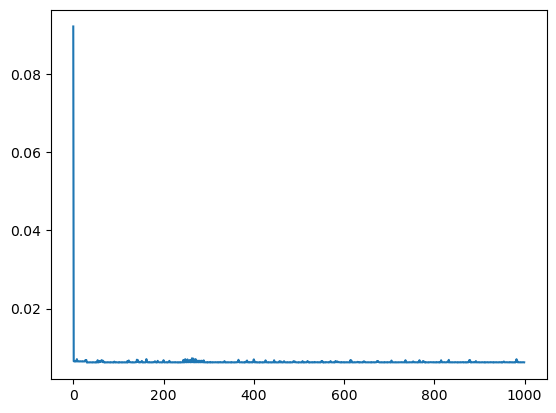

In [7]:
plt.plot(inference_times)

In [8]:
# discard first 10 runs to avoid JIT or cache effects
print(f"mean of inference times:{np.mean(inference_times[10:])}")
print(f"standard deviation of inference times:{np.std(inference_times[10:])}")

mean of inference times:0.00632237834159774
standard deviation of inference times:0.00013514237366344674
